In [53]:
import pandas as pd
import os
import numpy as np
# add reading window size as part of code
wsize=80
%matplotlib inline
os.chdir('/Users/vinayswamy/NIH/eyesplice_predictor/')
pd.core.common.random_state(None)
np.random.seed(8123)


In [25]:
col_names=['seqid', 'wstart','wend','ID']+list(range(80))
c_cols=list(range(80))
df=pd.read_csv('data/cleaned_cov/SRS2305609_bp_features.tsv.gz', 
               sep='\t', header=None, names=col_names)

In [26]:
df.shape

(118713, 84)

In [10]:
df.head()

,seqid,wstart,wend,ID,0,1,2,3,4,5,...,70,71,72,73,74,75,76,77,78,79
0,chr1,12139,12219,SL_0,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
1,chr1,13334,13414,EL_0,1,1,1,1,1,2,...,1,1,1,1,1,1,1,1,1,1
2,chr1,14420,14500,exon_7,9,9,9,9,9,9,...,131,131,136,136,138,138,138,138,138,139
3,chr1,16669,16749,exon_6,10,10,10,10,10,8,...,117,119,121,121,121,122,122,122,122,122
4,chr1,17246,17326,exon_5,354,390,390,407,401,404,...,380,391,385,420,419,418,414,417,413,414


In [18]:
df['ID'].str.replace('\d+','').unique()



pd.Series(lab_col).value_counts()

3    33918
2    33918
1    33918
0    16959
dtype: int64

In [50]:
'''
need to do 3 things - reverse the SL columns,make label column, and remove low count features
for removing low counts, going to switch to doing it  piece by piece
'''
sl=df[df['ID'].str.contains('SL')].reset_index(drop=True)
el=df[df['ID'].str.contains('EL')].reset_index(drop=True)
intron=df[df['ID'].str.contains('intron')].reset_index(drop=True)
exon=df[df['ID'].str.contains('exon')].reset_index(drop=True)
rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
sl_rev=sl.loc[:,rev_idx]
sl_rev.columns=col_names
all_junc=pd.concat([el, sl_rev]).reset_index(drop=True)
keep_junc=all_junc.loc[:, c_cols].sum(axis=1) >=80
all_junc=all_junc[keep_junc]
keep_exon=exon.loc[:,c_cols].sum(axis=1) >=80
exon=exon[keep_exon]
intron_sums=intron.loc[:,c_cols].sum(axis=1)
intron_sums.quantile([.1,.2,.3,.4,.6,.7,.8,.9, 1])# mjority are 0, but i'll keep it up till 20 for sake of completeness.
keep_intron=intron_sums <= 20
intron=intron[keep_intron]

min_count= min(all_junc.ID.str.contains('ref').sum(),
              all_junc.shape[0]-all_junc.ID.str.contains('ref').sum() ,
              intron.shape[0],
              exon.shape[0])
complete_data=pd.concat([all_junc[all_junc['ID'].str.contains('ref')].sample(min_count, ),
                         all_junc[~all_junc['ID'].str.contains('ref')].sample(min_count),
                         intron.sample(min_count),
                         exon.sample(min_count)
                        ]).reset_index()

lab_col=list()
'''
0=alt_splice junctino
1=no_splice junction
2=exon
3=not exon
'''
for lab in complete_data['ID']:
    if 'intron' in lab:
        lab_col.append(3)
    elif 'exon' in lab:
        lab_col.append(2)
    elif 'ref' in lab:
        lab_col.append(1)
    else:
        lab_col.append(0)

complete_data['Y']=lab_col


In [51]:
complete_data['Y'].value_counts()

3    11732
2    11732
1    11732
0    11732
Name: Y, dtype: int64

In [56]:
# above wrapped into a function for multiple sample use.
def pre_process(path, cut_off=wsize):
    col_names=['seqid', 'wstart','wend','ID']+list(range(80))
    c_cols=list(range(80))
    df=pd.read_csv(path, sep='\t', header=None, names=col_names)
    sl=df[df['ID'].str.contains('SL')].reset_index(drop=True)
    el=df[df['ID'].str.contains('EL')].reset_index(drop=True)
    intron=df[df['ID'].str.contains('intron')].reset_index(drop=True)
    exon=df[df['ID'].str.contains('exon')].reset_index(drop=True)
    rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
    sl_rev=sl.loc[:,rev_idx]
    sl_rev.columns=col_names
    all_junc=pd.concat([el, sl_rev]).reset_index(drop=True)
    keep_junc=all_junc.loc[:, c_cols].sum(axis=1) >=80
    all_junc=all_junc[keep_junc]
    keep_exon=exon.loc[:,c_cols].sum(axis=1) >=80
    exon=exon[keep_exon]
    intron_sums=intron.loc[:,c_cols].sum(axis=1)
    intron_sums.quantile([.1,.2,.3,.4,.6,.7,.8,.9, 1])# majority are 0, but i'll keep it up till 20 for sake of completeness.
    keep_intron=intron_sums <= 20
    intron=intron[keep_intron]

    min_count= min(all_junc.ID.str.contains('ref').sum(),
                  all_junc.shape[0]-all_junc.ID.str.contains('ref').sum() ,
                  intron.shape[0],
                  exon.shape[0])
    complete_data=pd.concat([all_junc[all_junc['ID'].str.contains('ref')].sample(min_count, ),
                             all_junc[~all_junc['ID'].str.contains('ref')].sample(min_count),
                             intron.sample(min_count),
                             exon.sample(min_count)
                            ]).reset_index(drop=True)

    lab_col=list()
    '''
    0=alt_splice junctino
    1=no_splice junction
    2=exon
    3=not exon
    '''
    for lab in complete_data['ID']:
        if 'intron' in lab:
            lab_col.append(3)
        elif 'exon' in lab:
            lab_col.append(2)
        elif 'ref' in lab:
            lab_col.append(1)
        else:
            lab_col.append(0)

    complete_data['Y']=lab_col
    return(complete_data)

In [57]:
data_1=pre_process('data/cleaned_cov/SRS2305609_bp_features.tsv.gz')
data_2=pre_process('data/cleaned_cov/SRS524515_bp_features.tsv.gz')
data_3=pre_process('data/cleaned_cov/HM7FMBBXX_16424741_S61_bp_features.tsv.gz')

In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
x_cols=list(range(80))
X=data_1.loc[:,x_cols]
Y=data_1['Y']
pca=PCA(n_components=2)
pcmat=pca.fit_transform(X)
drX=pd.DataFrame(data=pcmat ,columns=['PC1', 'PC2']).assign(lab=Y)

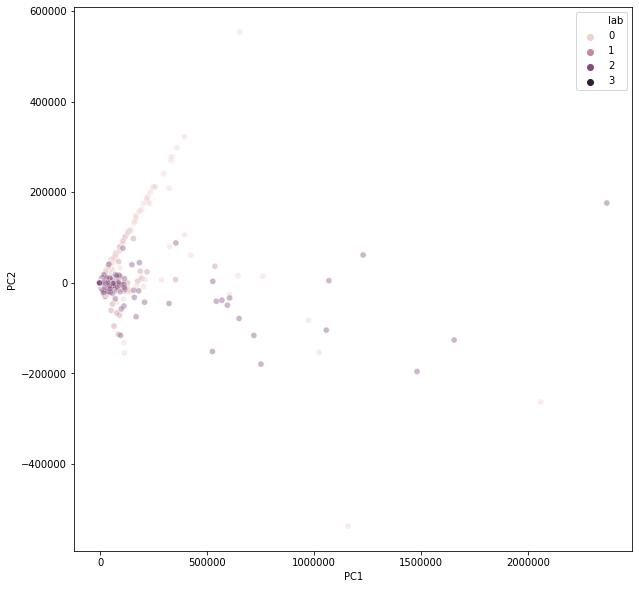

In [66]:
%matplotlib inline
plt.figure(figsize=(10,10))
sns.scatterplot(data=drX, x='PC1', y='PC2', hue='lab', alpha=.4)

In [67]:
pca.explained_variance_ratio_

array([0.90865101, 0.06839068])

PCA does not look that great,and I didn't boff the labels/ orientation, which leads me to ask, do we really need bp level info? may haps just the averages will work.

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
import pandas_ml as pml

def ROC_plot(Y_test, Y_prob):
    fpr, tpr, thresholds=roc_curve(Y_test, Y_prob)
    auc=roc_auc_score(Y_test, Y_prob)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
def PR_plot(Y_test, Y_prob):
    pre, rec, thresholds = precision_recall_curve(Y_test, Y_prob)
    auc = average_precision_score(Y_test, Y_prob)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( auc))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('')
    plt.legend(loc="lower right")
    plt.show()   

def train_model(X,Y, model):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.3, random_state=8976, stratify=Y)
    model.fit(X_train, Y_train)
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    labs=model.classes_
    print('confusion matrix\n\n')
    print(pd.DataFrame(confusion_matrix(Y_test, Y_pred), index=labs, columns=labs))
    print('\n\nclassification report\n\n')
    print(classification_report(y_pred=Y_pred,y_true=Y_test))
    #ROC_plot(Y_test , Y_prob)
    #PR_plot(Y_test,Y_prob)
    return(model)

In [99]:
model=XGBClassifier(random_state=2234)
model_names=['Random Forest', 'XGBC', 'KNN']
X_1=data_1.loc[:,x_cols]
Y_1=data_1['Y']
trained_model= train_model(X_1, Y_1, model)
# Y_1.value_counts()
# X_train, X_test, Y_train, Y_test = train_test_split(X_1,Y_1, test_size=.3, random_state=8976, stratify=Y_1)
# model.fit(X_train, Y_train)


confusion matrix


      0     1     2     3
0  1482   637  1401     0
1   649  1593  1278     0
2   755   169  2596     0
3     0     0     0  3519


classification report


              precision    recall  f1-score   support

           0       0.51      0.42      0.46      3520
           1       0.66      0.45      0.54      3520
           2       0.49      0.74      0.59      3520
           3       1.00      1.00      1.00      3519

    accuracy                           0.65     14079
   macro avg       0.67      0.65      0.65     14079
weighted avg       0.67      0.65      0.65     14079



In [104]:
'''
okay well thats clearly not working
it can easily pick out an exon, but makes sense that the distinction between half an exon and a whole exon vs an alt splice exon is not that clear, so we'll try a couple of things
-log transform
-separate clases and retrain
-prune training data a little more, but I'm hesitant to do this cause It'll overfit the model
'''
juncs=data_2.query('Y == 0 | Y==1')
model=XGBClassifier(random_state=2234)
X_j=juncs.loc[:,x_cols]
Y_j=juncs['Y']
m=train_model(X_j, Y_j, model)

confusion matrix


      0     1
0  1526   920
1   912  1534


classification report


              precision    recall  f1-score   support

           0       0.63      0.62      0.62      2446
           1       0.63      0.63      0.63      2446

    accuracy                           0.63      4892
   macro avg       0.63      0.63      0.63      4892
weighted avg       0.63      0.63      0.63      4892

